In [1]:
!pip install dice_ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 16.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 937.7/937.7 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 14.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import shap
import sklearn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import dice_ml
from dice_ml import Dice
from dice_ml.utils import helpers

/root/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# First, load the dataset
df = pd.read_csv('breast_cancer.csv')
df = df.dropna(axis=1)  # Drop columns with missing values
df.drop(columns=['id'], inplace=True)

# Manually encode labels: M (malignant) = 1 and B (benign) = 0
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [9]:
X = df.drop('diagnosis', axis=1)  # All columns except 'diagnosis'
y = df['diagnosis']  # Only the 'diagnosis' column

# Split the data into training and testing sets
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Fitting a RF classifier
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(train, labels_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [13]:
y_pred = rf.predict(test)
print("Accuracy: ", accuracy_score(labels_test, y_pred))

Accuracy:  0.9649122807017544


In [15]:
# SHAP explanations
explainer = shap.KernelExplainer(rf.predict, shap.kmeans(train, 10))
nb_points_explain = round(0.2*train.shape[0])
shap_values = explainer(train.iloc[0:nb_points_explain, :])

100%|██████████| 91/91 [01:37<00:00,  1.07s/it]


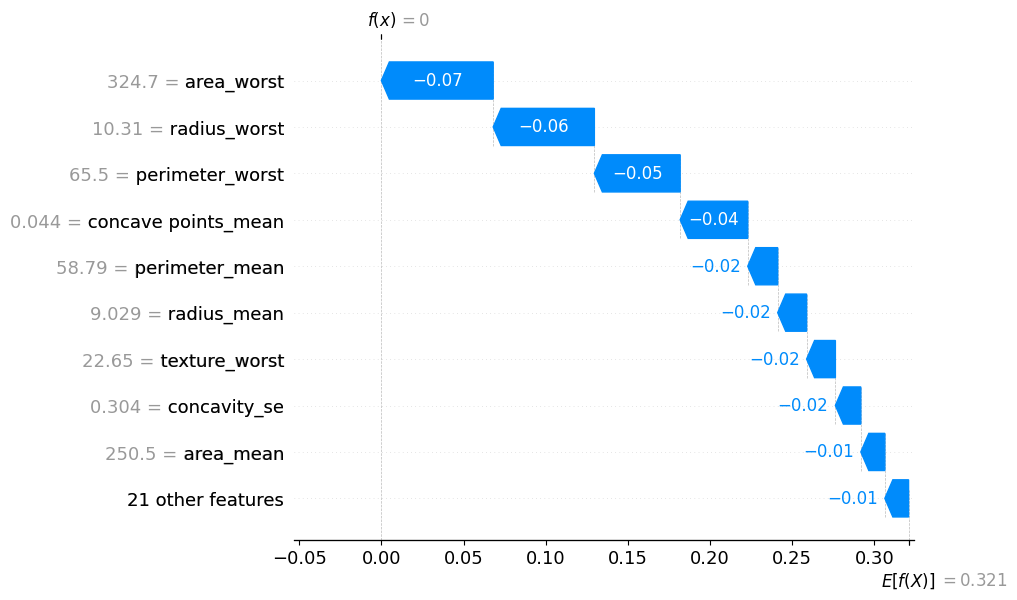

In [17]:
# Waterfall plot for a the benign explanation
shap.plots.waterfall(shap_values[0])

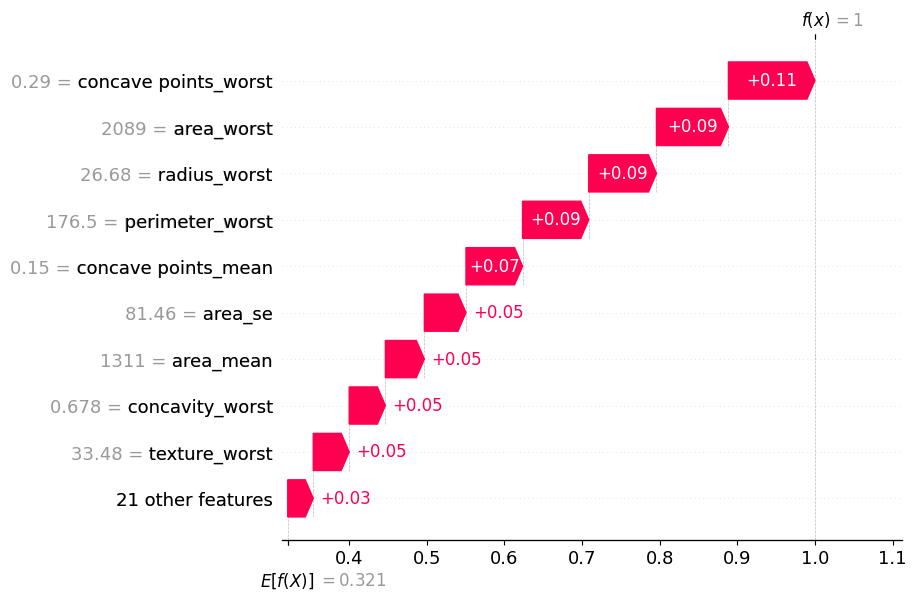

In [19]:
# Waterfall plot for a the malignant explanation
shap.plots.waterfall(shap_values[1])

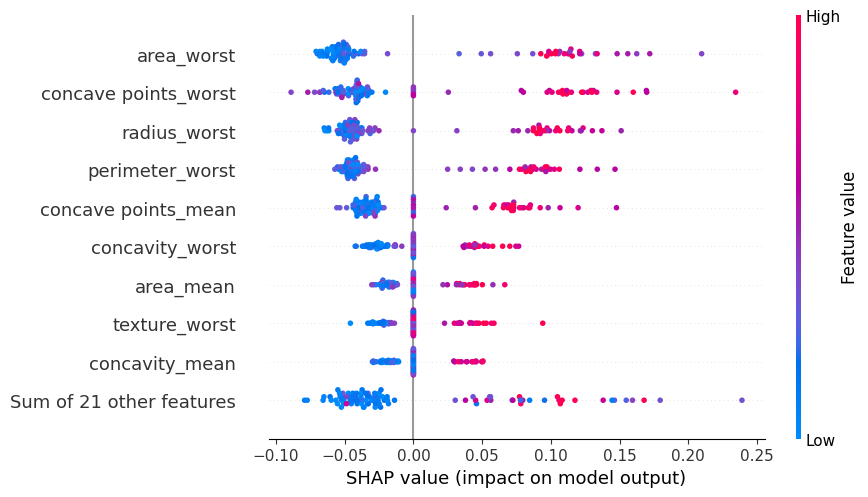

In [21]:
# Beeswarm (aka summary plot)
shap.plots.beeswarm(shap_values)

In [23]:
# Wrap data and model for DiCE
# Telling DiCE which features are continuous vs. categorical
continuous_features = list(X.columns)  # All numeric in this dataset
categorical_features = []  # No categorical features in this dataset

# Create a DiCE data object
data_dice = dice_ml.Data(dataframe=df,continuous_features=continuous_features,outcome_name='diagnosis')

# Create a model wrapper for DiCE
model_dice = dice_ml.Model(model=rf, backend='sklearn')

In [25]:
#Initialize DiCE explainer
dice = Dice(data_dice, model_dice)

In [27]:
# Pick an index of the sample that you want to explain
i = 5  
query_instance = test.iloc[i:i+1]
print("Original prediction:", rf.predict(query_instance)[0])


Original prediction: 1


In [29]:
# Generate counterfactuals
cf = dice.generate_counterfactuals(query_instance, total_CFs=3,desired_class="opposite") 

100%|██████████| 1/1 [00:03<00:00,  3.46s/it]


In [31]:
# Visualize counterfactuals
cf.visualize_as_dataframe()

Query instance (original outcome : 1)


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,20.6,29.33,140.100006,1265.0,0.1178,0.277,0.3514,0.152,0.2397,0.07016,...,39.419998,184.600006,1821.0,0.165,0.8681,0.9387,0.265,0.4087,0.124,1



Diverse Counterfactual set (new outcome: 0)


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,21.24,10.13,140.10,643.9,0.1178,0.2770,0.3514,0.152,0.1353,0.07913,...,12.87,96.1,261.2,0.0721,0.68,0.9387,0.1,0.4087,0.07063,0
1,21.24,10.13,164.54,643.9,0.1178,0.2770,0.3514,0.152,0.1353,0.07913,...,12.87,96.1,261.2,0.0721,0.68,0.9387,0.1,0.4087,0.07063,0
2,21.24,10.13,164.54,643.9,0.1178,0.2118,0.3514,0.152,0.1353,0.07913,...,12.87,96.1,261.2,0.0721,0.68,0.9387,0.1,0.4087,0.07063,0
